# UNICEF — connection between living conditions and school performance

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.


## Импорт библиотек и исходного DataSet

In [1]:
# Ипорты библиотек

import pandas as pd
import numpy as np
import re
from itertools import combinations
from scipy.stats import ttest_ind

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Настройки и конфигурации

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

%matplotlib inline

In [3]:
# Исходный DataSet

unisef = pd.read_csv('stud_math.csv')
unisef

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0
391,MS,M,17,U,LE3,T,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,no,no,no,no,no,-3.0,yes,yes,no,2.0,4.0,5.0,2.0,3.0,80.0
392,MS,M,21,R,GT3,T,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,no,no,no,no,-3.0,NaN,no,no,5.0,5.0,3.0,3.0,3.0,35.0
393,MS,M,18,R,LE3,T,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,no,no,no,NaN,no,-3.0,yes,yes,no,4.0,4.0,1.0,5.0,0.0,50.0


## Напишем необходимые функции

In [4]:
# My_Fuc

def iqr(data):
    # возвращает iqr
    return (data.quantile(0.75) - data.quantile(0.25))


def outlier_border(data):
    # возвращает кортеж с левой и правой границей выбросов
    bord_left = data.quantile(0.25) - 1.5*iqr(data)
    bord_right = data.quantile(0.75) + 1.5*iqr(data)
    return (bord_left, bord_right)


def data_wthout_outs(data):
    # возвращает отфильрованный датафрейм без выбросов
    return data.loc[data.between(outlier_border(data)[0],
                                 outlier_border(data)[1])]


def num_uniq_val(data):
    # возвращает количество уникальных значений
    return len(data.index)


def get_boxplot(column, result, df):
    # отрисовывает boxplot
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column, y=result,
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


def get_stat_dif(column, result, df):
    # находит статичтически различимые колонки
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], result],
                     df.loc[df.loc[:, column] == comb[1], result]).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
            

def validation(column):
    # проверка соответсвия значения в колонке заданному шаблону
    unvalid_vals_dict = {'column': [], 'has_unvalid': [], 'unvalids': []}
    unvalid_vals_dict['column'].append(column)

    for j in unisef[column]:
        if not bool(re.fullmatch(str(valid_paterns[column]), str(j))):
            unvalid_vals_dict['unvalids'].append(str(j))

    if len(unvalid_vals_dict['unvalids']):
        unvalid_vals_dict['has_unvalid'].append('yes')
    else:
        unvalid_vals_dict['has_unvalid'].append('no')

    return unvalid_vals_dict

## Первичная обработка данных

### Проанализируем наименование столбцов, на предмет нужно ли их обрабатывать 

In [5]:
for i in unisef.columns:
    print(i)

school
sex
age
address
famsize
Pstatus
Medu
Fedu
Mjob
Fjob
reason
guardian
traveltime
studytime
failures
schoolsup
famsup
paid
activities
nursery
studytime, granular
higher
internet
romantic
famrel
freetime
goout
health
absences
score


'studytime, granular', непонятная метрика без описания.

строк не так много, поэтому можно быстро пробежаться по уникальным значениям в каждой колонке

In [6]:
for i in unisef.columns:
    print('===')
    print(i)
    print()
    print(unisef[i].value_counts())
    print('===')
    print()
    print()

===
school

GP    349
MS     46
Name: school, dtype: int64
===


===
sex

F    208
M    187
Name: sex, dtype: int64
===


===
age

16    104
17     98
15     82
18     82
19     24
20      3
21      1
22      1
Name: age, dtype: int64
===


===
address

U    295
R     83
Name: address, dtype: int64
===


===
famsize

GT3    261
LE3    107
Name: famsize, dtype: int64
===


===
Pstatus

T    314
A     36
Name: Pstatus, dtype: int64
===


===
Medu

4.0    131
2.0    102
3.0     97
1.0     59
0.0      3
Name: Medu, dtype: int64
===


===
Fedu

2.0     106
3.0      96
4.0      88
1.0      78
0.0       2
40.0      1
Name: Fedu, dtype: int64
===


===
Mjob

other       133
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64
===


===
Fjob

other       197
services    102
teacher      29
at_home      16
health       15
Name: Fjob, dtype: int64
===


===
reason

course        137
home          104
reputation    103
other          34
Name: reason, dtype: int6

### Определим наличае невалидных значений

In [7]:
# используем регулярные выражения

valid_paterns = {'school':       r'nan|\S*',
                 'sex':          r'nan|F|M',
                 'age':          r'nan|\d\d',
                 'address':      r'nan|U|R',
                 'famsize':      r'nan|LE3|GT3',
                 'Pstatus':      r'nan|T|A',
                 'Medu':         r'nan|0\.0|1\.0|2\.0|3\.0|4\.0',
                 'Fedu':         r'nan|0\.0|1\.0|2\.0|3\.0|4\.0',
                 'Mjob':         r'nan|\w*',
                 'Fjob':         r'nan|\w*',
                 'reason':       r'nan|\w*',
                 'guardian':     r'nan|\w*',
                 'traveltime':   r'nan|1\.0|2\.0|3\.0|4\.0',
                 'studytime':    r'nan|1\.0|2\.0|3\.0|4\.0',
                 'failures':     r'nan|0\.0|1\.0|2\.0|3\.0',
                 'schoolsup':    r'nan|yes|no',
                 'famsup':       r'nan|yes|no',
                 'paid':         r'nan|yes|no',
                 'activities':   r'nan|yes|no',
                 'nursery':      r'nan|yes|no',
                 'higher':       r'nan|yes|no',
                 'internet':     r'nan|yes|no',
                 'romantic':     r'nan|yes|no',
                 'famrel':       r'nan|1\.0|2\.0|3\.0|4\.0|5\.0',
                 'freetime':     r'nan|1\.0|2\.0|3\.0|4\.0|5\.0',
                 'goout':        r'nan|1\.0|2\.0|3\.0|4\.0|5\.0',
                 'health':       r'nan|1\.0|2\.0|3\.0|4\.0|5\.0',
                 'absences':     r'nan|\d*\.\d*',
                 'score':        r'nan|\d*\.\d*'}

In [8]:
# создадим датафрэйм с невалидными значениями

unvalid_vals_dict = {'column': [], 'has_unvalid': [], 'unvalids': []}
for i in valid_paterns.keys():
    unvalid_vals_dict['column'].append(validation(i)['column'][0])
    unvalid_vals_dict['has_unvalid'].append(validation(i)['has_unvalid'][0])
    unvalid_vals_dict['unvalids'].append(validation(i)['unvalids'])

unvalid_vals_df = pd.DataFrame(unvalid_vals_dict)
unvalid_vals_df[unvalid_vals_df['has_unvalid'] == 'yes']


,column,has_unvalid,unvalids
7,Fedu,yes,[40.0]
23,famrel,yes,[-1.0]


Видно что по одному не валидному значению находится только в двух столбца, 
остальные значения валидные или Nan.

Примем стратеги анализа этих столбцов:

1-я Гипотеза что данные заполнили с опечаткой и это Fedu - 4, famrel - 1

2-я Гипотеза что данные ошибочны и их нужно исключить из анализа 

Остальные значения валидны.

Для проекта будем использовать 1 стратегию

## Первичный анализ данных в столбцах

Суть проекта — отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

In [9]:
#  для работы и формирования целевого Df , сделаем копию основного Df.
unsf = unisef.copy()

In [10]:
# Заменим значения на предполагаемые

unsf.Fedu = unsf.Fedu.apply(lambda x: 4.0 if x == 40.0 else x)
unsf.famrel = unsf.famrel.apply(lambda x: 1.0 if x == -1.0 else x)

Теперь можно быть уверенными что не валидных значений нет, так же в данных нет пустых значений, все они в виде Nan, поэтому автоматически отфильтруются в df.

Остается в рамках Первичного анализа:

1. Оценить распределение признака для числовых переменных, устраните выбросы.
2. Оценить количество уникальных значений для номинативных переменных.

In [97]:
unsf.info()

# Для каждого столбца можно увидеть количество непустых значений

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               381 non-null    object 
 1   sex                  381 non-null    object 
 2   age                  381 non-null    int64  
 3   address              366 non-null    object 
 4   famsize              357 non-null    object 
 5   Pstatus              338 non-null    object 
 6   Medu                 378 non-null    float64
 7   Fedu                 357 non-null    float64
 8   Mjob                 363 non-null    object 
 9   Fjob                 346 non-null    object 
 10  reason               364 non-null    object 
 11  guardian             351 non-null    object 
 12  traveltime           353 non-null    float64
 13  studytime            376 non-null    float64
 14  failures             359 non-null    float64
 15  schoolsup            372 non-null    obj

Количество непустых значений в каждом столбце, не велико.

### scholl (номинативная переменная)

In [12]:
school_df = pd.DataFrame(unsf['school'].value_counts())
school_df

,school
GP,349
MS,46


In [13]:
# Уникальные значения
num_uniq_val(school_df)

2

Данные соответсвуют шаблону. Большинство челововек из школы "GB".
Мы не знаем чем отличаются школы, но точно знаем - в эту метрику в нашем
анализе можно рассматривать как, условное качество преподавания предмета.
Обязательно проверим эту гипотезу ниже.


### sex (номинативная переменная)

In [14]:
sex_df = pd.DataFrame(unsf['sex'].value_counts())
sex_df

,sex
F,208
M,187


In [15]:
num_uniq_val(sex_df)

2

Данные соответсвуют шаблону. По гендерному признаку выборка разделена примерно поровну, с небольшим перевосом в сторону девушек.

### age (числовая переменная)

In [16]:
age_df = pd.DataFrame(unsf['age'].value_counts())
age_df

,age
16,104
17,98
15,82
18,82
19,24
20,3
21,1
22,1


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

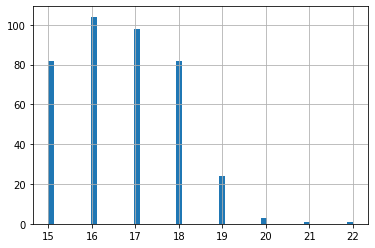

In [17]:
unsf.age.hist(bins=50)
unsf.age.describe()

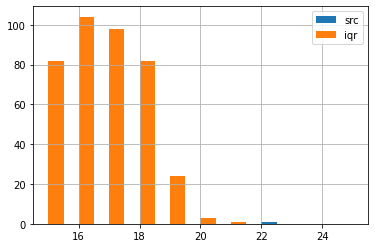

In [18]:
unsf.age.hist(bins=20, range=(15, 25), label='src')
data_wthout_outs(unsf.age).hist(bins=20, range=(15, 25), label='iqr')
plt.legend()

Определим есть ли выбросы.

1.  Сначала применим формулу iqr
2.  Рассматривая значения внутри границ выбросов, и всю выборку вместе -  приходим к выводу

Вывод: В анализе необходимо рассматривать всю выборку, так как значения валидны и каждое измерение вполне реальный человек, руководствуясь здравым смыслом, в анализе будем рассматривать исходную выборку.

### address (номинативная переменная)

In [19]:
address_df = pd.DataFrame(unsf['address'].value_counts())
address_df

,address
U,295
R,83


In [20]:
num_uniq_val(address_df)

2

Данные соответсвуют шаблону. Большинство человек живет в городе

### famsize (номинативная переменная)

In [21]:
famsize_df = pd.DataFrame(unsf['famsize'].value_counts())
famsize_df

,famsize
GT3,261
LE3,107


In [22]:
num_uniq_val(famsize_df)

2

Данные соответсвуют шаблону. Большинство человек живет в больших семьях

### Pstatus (номинативная переменная)

In [23]:
Pstatus_df = pd.DataFrame(unsf['Pstatus'].value_counts())
Pstatus_df

,Pstatus
T,314
A,36


In [24]:
num_uniq_val(Pstatus_df)

2

Данные соответсвуют шаблону. Большинство человек живет в полных семьях.

### Medu (числовая переменная)

In [25]:
Medu_df = pd.DataFrame(unsf['Medu'].value_counts())
Medu_df

,Medu
4.0,131
2.0,102
3.0,97
1.0,59
0.0,3


In [26]:
num_uniq_val(Medu_df)

5

count    392.000000
mean       2.750000
std        1.098127
min        0.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        4.000000
Name: Medu, dtype: float64

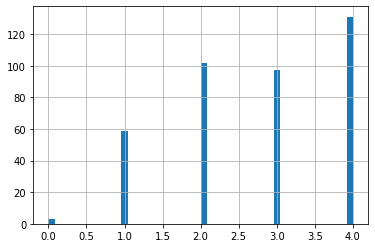

In [27]:
unsf.Medu.hist(bins = 50)
unsf.Medu.describe()

Данные соответсвуют шаблону. У Большинства человек мамы не имеют высшего образования.

### Fedu  (числовая переменная)

In [28]:
Fedu_df = pd.DataFrame(unsf['Fedu'].value_counts())
Fedu_df

,Fedu
2.0,106
3.0,96
4.0,89
1.0,78
0.0,2


In [29]:
num_uniq_val(Fedu_df)

5

count    371.000000
mean       2.517520
std        1.088808
min        0.000000
25%        2.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: Fedu, dtype: float64

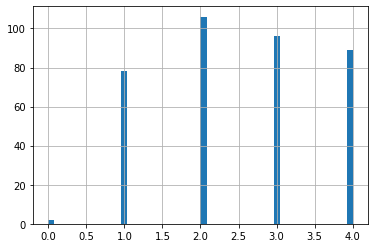

In [30]:
unsf.Fedu.hist(bins = 50)
unsf.Fedu.describe()

Данные соответсвуют шаблону. У Большинства человек папы не имеют высшего образования. Причем это распределение более ярко выраженно чем у мам.

### Mjob (номинативная переменная)

In [31]:
Mjob_df = pd.DataFrame(unsf['Mjob'].value_counts())
Mjob_df

,Mjob
other,133
services,98
at_home,58
teacher,55
health,32


In [32]:
num_uniq_val(Mjob_df)

5

<AxesSubplot:>

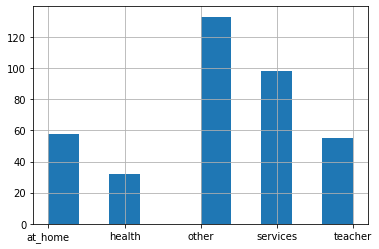

In [33]:
unsf.Mjob.hist()

Данные соответсвуют шаблону. Отдельно выборку рассматривать по этому пораметру не имеет смысла.

### Fjob (номинативная переменная)

In [34]:
Fjob_df = pd.DataFrame(unsf['Fjob'].value_counts())
Fjob_df

,Fjob
other,197
services,102
teacher,29
at_home,16
health,15


In [35]:
num_uniq_val(Fjob_df)

5

<AxesSubplot:>

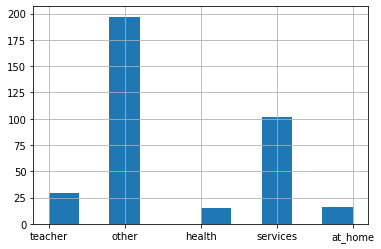

In [36]:
unsf.Fjob.hist()

Данные соответсвуют шаблону. Уникальных параметров 5. Отдельно выборку рассматривать по этому пораметру не имеет смысла.

### reason (номинативная переменная)


In [37]:
reason_df = pd.DataFrame(unsf['reason'].value_counts())
reason_df

,reason
course,137
home,104
reputation,103
other,34


In [38]:
num_uniq_val(reason_df)

4

Данные соответсвуют шаблону. Уникальных параметров 4. Большая часть выборки распределена между ('home' - близость к дому, 'reputation' - репутация школы, 'course' - образовательная программа). Где самым важным для учащихся является образовательная программа.

### guardian (номинативная переменная)


In [39]:
guardian_df = pd.DataFrame(unsf['guardian'].value_counts())
guardian_df

,guardian
mother,250
father,86
other,28


In [40]:
num_uniq_val(guardian_df)

3

Данные соответсвуют шаблону. Большинство опекунов мамы.

### traveltime (числовая переменная)


In [41]:
traveltime_df = pd.DataFrame(unsf['traveltime'].value_counts())
traveltime_df

,traveltime
1.0,242
2.0,96
3.0,22
4.0,7


In [42]:
num_uniq_val(traveltime_df)

4

Данные соотвествуют шаблону. 
Интересно заметить что не смотря на то что причины выбора школы является качесвто образования, более 80 процентов выборки живут достаточно близко.

count    367.000000
mean       1.438692
std        0.694181
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: traveltime, dtype: float64

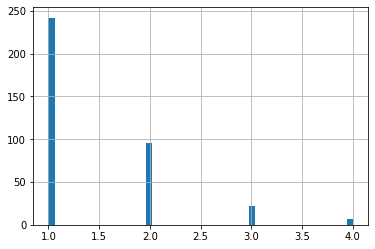

In [43]:
unsf['traveltime'].hist(bins=50)
unsf['traveltime'].describe()

### studytime (числовая переменная)


In [44]:
studytime_df = pd.DataFrame(unsf['studytime'].value_counts())
studytime_df

,studytime
2.0,194
1.0,103
3.0,64
4.0,27


In [45]:
num_uniq_val(studytime_df)

4

Данные соотвествуют шаблону. Только 4 часть выборки посвящает почти все свободное время учебе.

count    388.000000
mean       2.038660
std        0.842078
min        1.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: studytime, dtype: float64

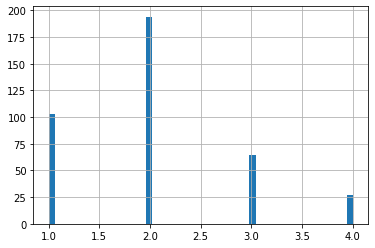

In [46]:
unsf['studytime'].hist(bins=50)
unsf['studytime'].describe()

### failures (числовая переменная)


In [47]:
failures_df = pd.DataFrame(unsf['failures'].value_counts())
failures_df

,failures
0.0,293
1.0,49
2.0,16
3.0,15


In [48]:
num_uniq_val(failures_df)

4

Данные соотвествуют шаблону. У большинства вполне беззаботная жизнь=)))

count    373.000000
mean       0.337802
std        0.743135
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        3.000000
Name: failures, dtype: float64

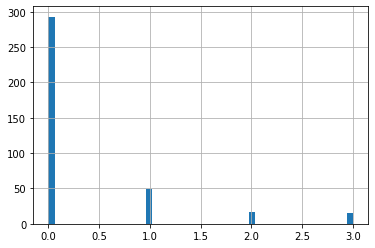

In [49]:
unsf['failures'].hist(bins=50)
unsf['failures'].describe()

### schoolsup (номинативная переменная)


In [50]:
schoolsup_df = pd.DataFrame(unsf['schoolsup'].value_counts())
schoolsup_df

,schoolsup
no,335
yes,51


In [51]:
num_uniq_val(schoolsup_df)

2

Данные соответсвуют шаблону. Параметр корелирует с параметром внеурочного время на учебу. Что очевидно.

### famsup (номинативная переменная)


In [52]:
famsup_df = pd.DataFrame(unsf['famsup'].value_counts())
famsup_df

,famsup
yes,219
no,137


In [53]:
num_uniq_val(famsup_df)

2

Данные соответсвуют шаблону. Да мнения родителей по поводу помощи своим детям дома всегда резко отличались.

### paid (номинативная переменная)


In [54]:
paid_df = pd.DataFrame(unsf['paid'].value_counts())
paid_df

,paid
no,200
yes,155


In [55]:
num_uniq_val(paid_df)

2

Данные соответсвуют шаблону. Весьма многим необходимы дополнительные занятия по математике. Интересно на сколько сильная связь между балом и этим параметром.

### activities (номинативная переменная)


In [56]:
activities_df = pd.DataFrame(unsf['activities'].value_counts())
activities_df

,activities
yes,195
no,186


In [57]:
num_uniq_val(activities_df)

2

Данные соответсвуют шаблону. Весьма многие занимаеются чем то кроме школы.

### nursery (номинативная переменная)


In [58]:
nursery_df = pd.DataFrame(unsf['nursery'].value_counts())
nursery_df

,nursery
yes,300
no,79


In [59]:
num_uniq_val(nursery_df)

2

Данные соответсвуют шаблону. Большинство посещало детский сад.

### studytime, granular (числовая, неизваестая переменная)

In [60]:
std_tm_gran_df = pd.DataFrame(unsf['studytime, granular'].value_counts())
std_tm_gran_df

,"studytime, granular"
-6.0,194
-3.0,103
-9.0,64
-12.0,27


count    388.000000
mean      -6.115979
std        2.526235
min      -12.000000
25%       -6.000000
50%       -6.000000
75%       -3.000000
max       -3.000000
Name: studytime, granular, dtype: float64

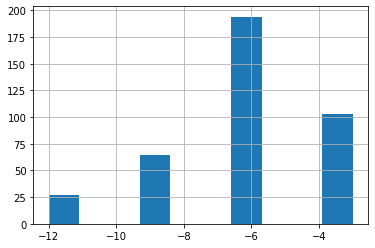

In [61]:
unsf['studytime, granular'].hist()
unsf['studytime, granular'].describe()

Выбросов нет, Данные однообразные

### higher (номинативная переменная)


In [62]:
higher_df = pd.DataFrame(unsf['higher'].value_counts())
higher_df

,higher
yes,356
no,19


In [63]:
num_uniq_val(higher_df)

2

Данные соответсвуют шаблону. Большинство говорит что желает получить высшее образование.

### internet (номинативная переменная)


In [64]:
internet_df = pd.DataFrame(unsf['internet'].value_counts())
internet_df

,internet
yes,305
no,56


In [65]:
num_uniq_val(internet_df)

2

Данные соответсвуют шаблону. Большинство имеет интернет

### romantic (номинативная переменная)


In [66]:
romantic_df = pd.DataFrame(unsf['romantic'].value_counts())
romantic_df

,romantic
no,240
yes,124


In [67]:
num_uniq_val(romantic_df)

2

Данные соответсвуют шаблону. Большинство состоит в романтических отношениях.

### famrel (числовая переменная)


In [68]:
famrel_df = pd.DataFrame(unsf['famrel'].value_counts())
famrel_df

,famrel
4.0,182
5.0,99
3.0,62
2.0,17
1.0,8


In [69]:
num_uniq_val(famrel_df)

5

count    368.000000
mean       3.942935
std        0.903824
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: famrel, dtype: float64

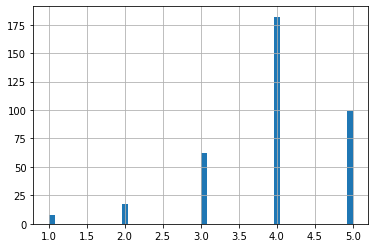

In [70]:
unsf['famrel'].hist(bins=50)
unsf['famrel'].describe()

Данные соответсвуют шаблону. Большинство оценивает свои отношения в семье выше чем нормальные.

### freetime (числовая переменная)


In [71]:
freetime_df = pd.DataFrame(unsf['freetime'].value_counts())
freetime_df

,freetime
3.0,153
4.0,112
2.0,63
5.0,38
1.0,18


In [72]:
num_uniq_val(freetime_df)

5

count    384.000000
mean       3.231771
std        0.993940
min        1.000000
25%        3.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: freetime, dtype: float64

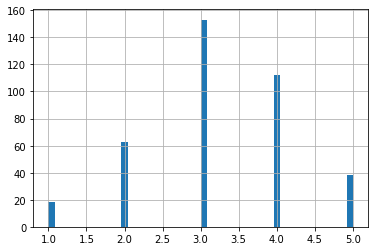

In [73]:
unsf['freetime'].hist(bins=50)
unsf['freetime'].describe()

Данные соответсвуют шаблону. Больше половины студентов считают что у них мало свободного времени.

### goout (числоваяпеременная)


In [74]:
goout_df = pd.DataFrame(unsf['goout'].value_counts())
goout_df

,goout
3.0,127
2.0,101
4.0,84
5.0,52
1.0,23


In [75]:
num_uniq_val(goout_df)

5

Данные соответсвуют шаблону. Данные корелируют с свободным временем, заметно без расчета.

count    387.000000
mean       3.105943
std        1.115896
min        1.000000
25%        2.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: goout, dtype: float64

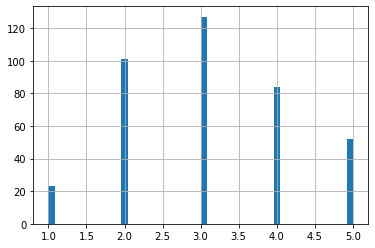

In [76]:
unsf['goout'].hist(bins=50)
unsf['goout'].describe()

### health (числовая переменная)


In [77]:
health_df = pd.DataFrame(unsf['health'].value_counts())
health_df

,health
5.0,138
3.0,89
4.0,63
1.0,47
2.0,43


In [78]:
num_uniq_val(health_df)

5

count    380.000000
mean       3.531579
std        1.396019
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: health, dtype: float64

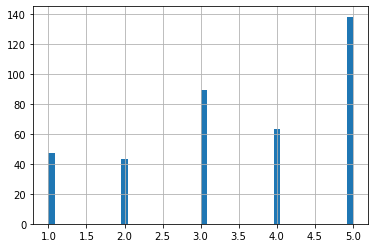

In [79]:
unsf['health'].hist(bins=50)
unsf['health'].describe()

Данные соответсвуют шаблону. Большинство считает свое здоровье хорошим.

### absences (числовая переменная)


array([[<AxesSubplot:title={'center':'absences'}>]], dtype=object)

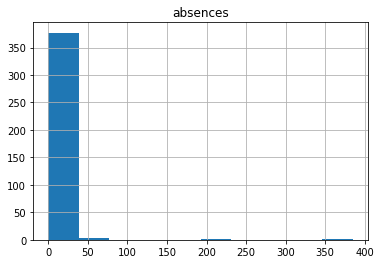

In [80]:
absences_df = pd.DataFrame(unsf['absences'])
absences_df.hist()

count    383.000000
mean       7.279373
std       23.465197
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

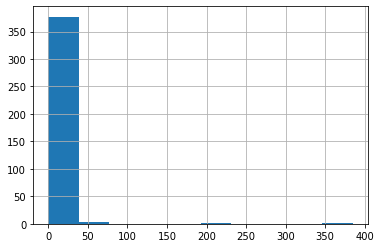

In [81]:
unsf.absences.hist()
unsf.absences.describe()

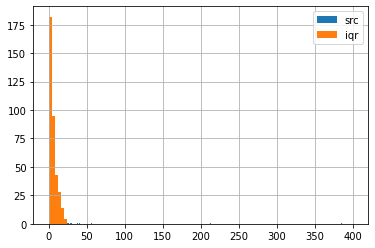

In [82]:
unsf.absences.hist(bins=400, range=(0, 400), label='src')
data_wthout_outs(unsf.absences).hist(bins=100, range=(0, 400), label='iqr')
plt.legend()

In [83]:
outlier_border(unsf.absences)

(-12.0, 20.0)

In [84]:
# есть намеки на выбросы, прежде чем исключать их из выборки посмотрим на эти строки

unsf[unsf['absences'] > 200]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,other,mother,1.0,2.0,0.0,yes,NaN,no,no,yes,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
390,MS,M,20,U,LE3,A,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,no,yes,yes,no,yes,-6.0,yes,no,no,5.0,5.0,4.0,4.0,212.0,45.0


Параметр "пропуск" не достаточно описан. Непонятно пропуск занятий по математике или в целом занятий в школе. Речь про математику, поэтому столько занятий провести сложно. исключим эти значения.

In [85]:
unsf = unsf[unsf['absences'] < 200]

### score (Целевая числовая переменная)

In [86]:
score_df = pd.DataFrame(unsf['score'].value_counts())
score_df

,score
50.0,53
55.0,46
0.0,36
65.0,31
75.0,31
60.0,29
40.0,29
70.0,27
45.0,26
80.0,16


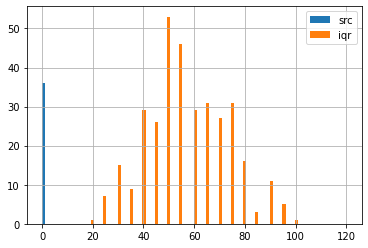

In [87]:
unsf.score.hist(bins=100, range=(0, 120), label='src')
data_wthout_outs(unsf.score).hist(bins=100, range=(0, 120), label='iqr')
plt.legend()

Выбросов нет, не сдать экзамен вполне реально.

 ## Корреляционный анализ

Истино числовыми значениями являются

1. score
2. age
3. absences
4. studytime, granular

Проведем корреляциооный анализ сначала с этими величинами

Остальные числовые переменные, это перевод номинативных признаков в численные

In [88]:
cor_1 = unsf[['score', 'age', 'absences', 'studytime, granular']]
#sns.pairplot(cor_1, kind='reg')

In [89]:
cor_1 = cor_1.corr()
cor_1

,score,age,absences,"studytime, granular"
score,1.000000,-0.149349,0.031698,-0.108754
age,-0.149349,1.000000,0.166773,0.002322
absences,0.031698,0.166773,1.000000,0.067734
"studytime, granular",-0.108754,0.002322,0.067734,1.000000


In [90]:
#sns.heatmap(data=cor_1.round(2), annot=True, cmap='coolwarm')

In [91]:
cor_2 = unsf[['score', 'age', 'absences', 'Medu', 'Fedu', 'traveltime','studytime, granular',
              'studytime', 'failures', 'famrel', 'freetime', 'goout', 'health']]

In [92]:
cor_2 = cor_2.corr()
# cor_2[(cor_2['score'] > 0.1) | (cor_2['score'] < -0.1)]

Остаются колонки для дальнейшей интерпретации : score, age, Medu, Fedu, studytime, failures ,goout, ,studytime, granular

<AxesSubplot:>

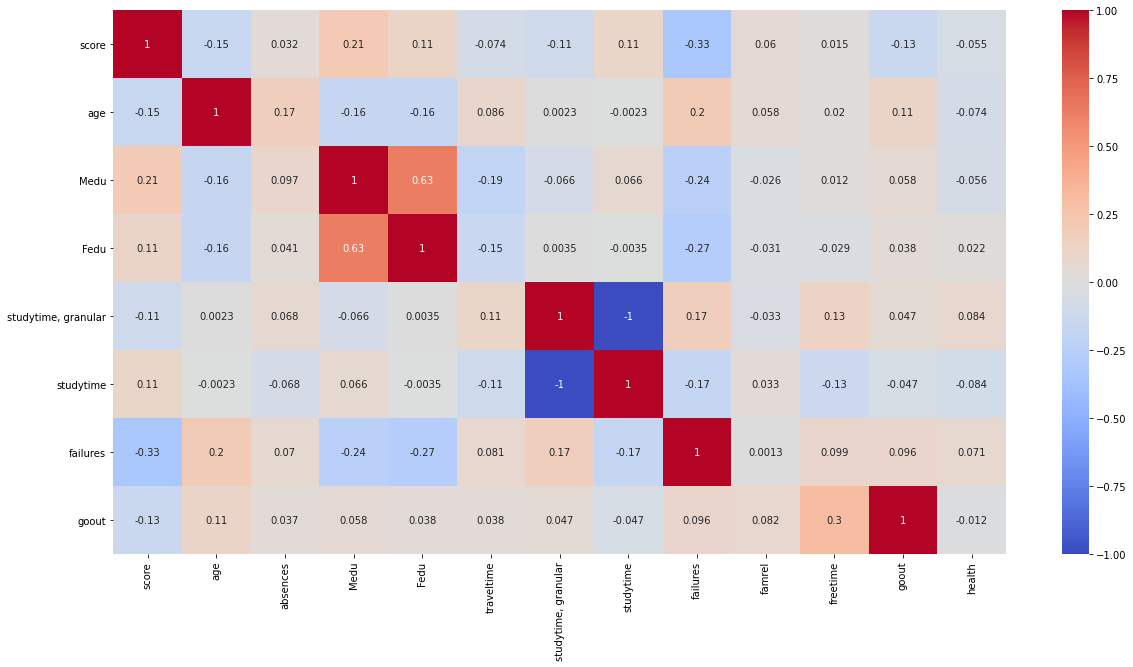

In [93]:
fig, ax = plt.subplots(figsize=(20,10))  
sns.heatmap(cor_2[(cor_2['score'] > 0.1) | (
    cor_2['score'] < -0.1)], annot=True, cmap='coolwarm',ax=ax, square = False)

## Анализ номинативных переменных

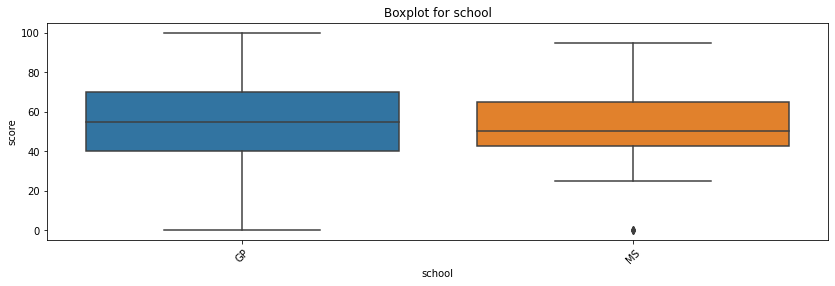

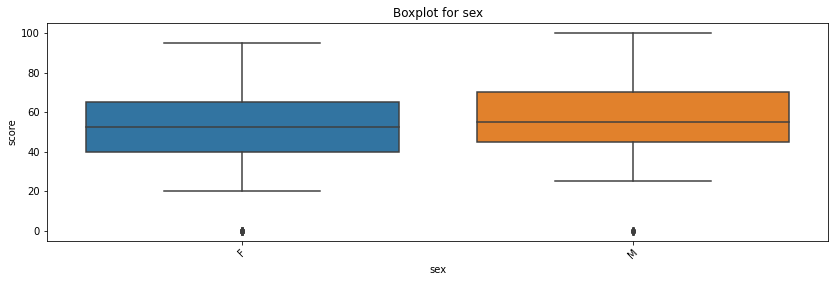

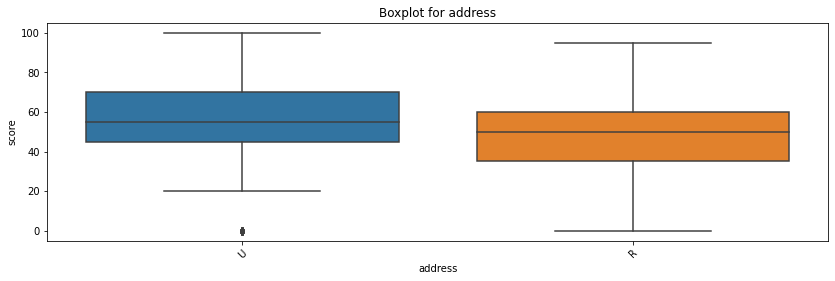

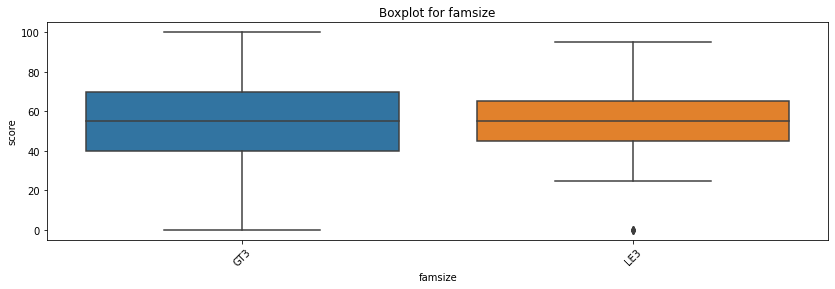

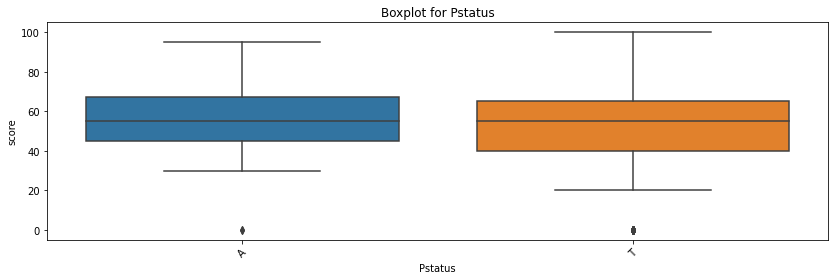

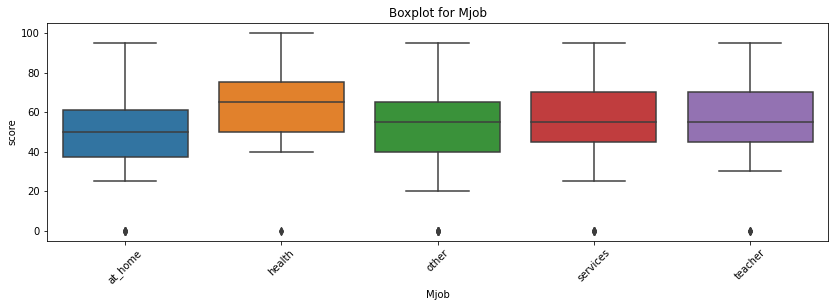

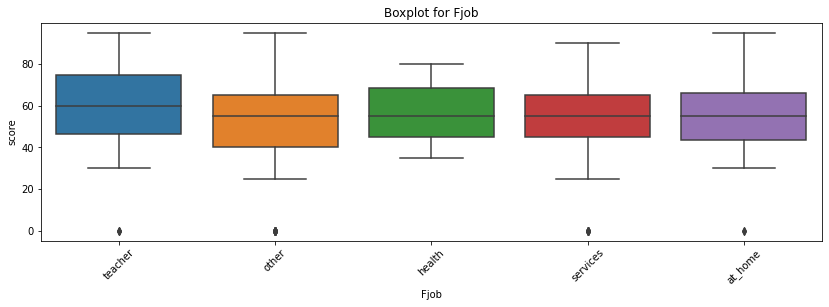

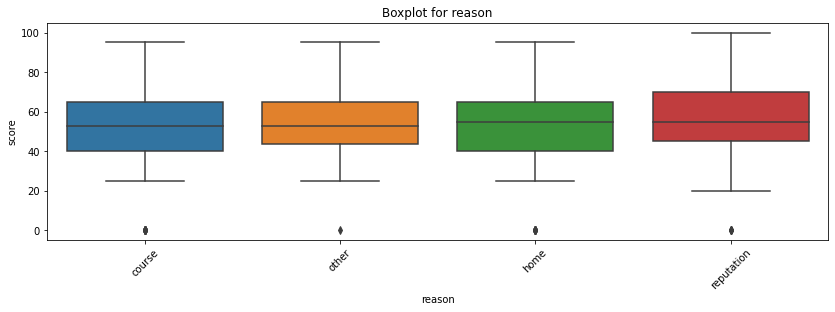

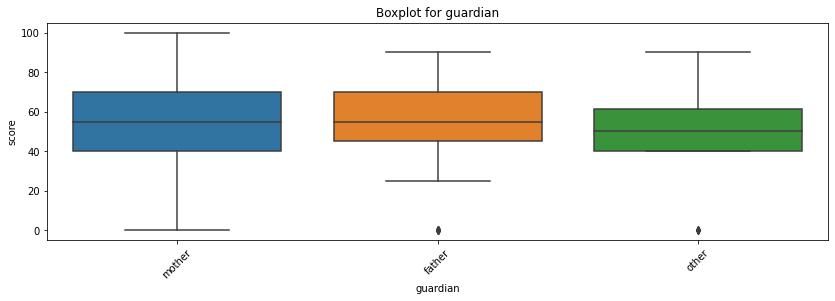

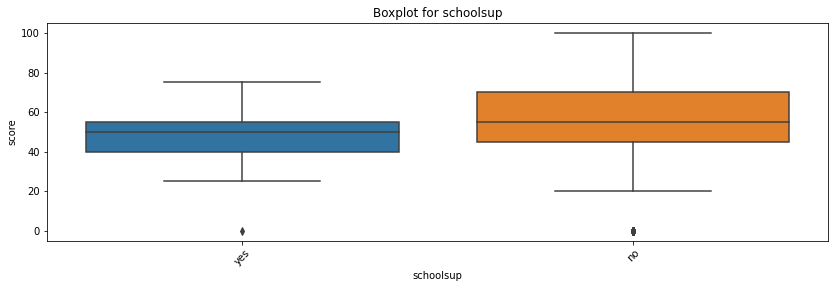

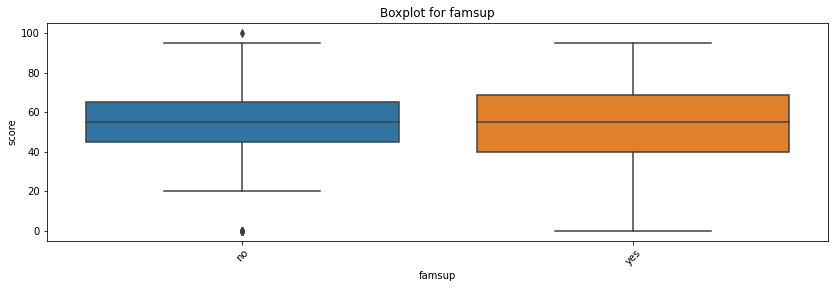

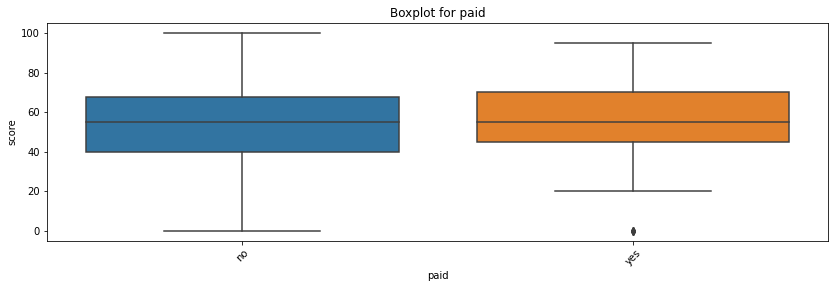

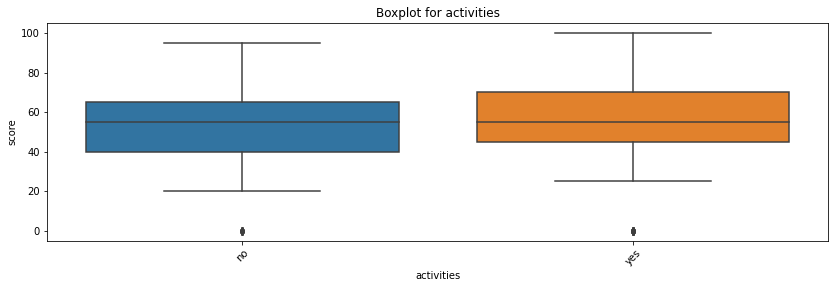

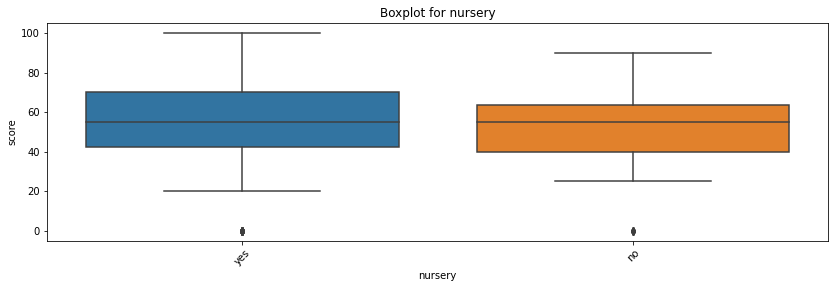

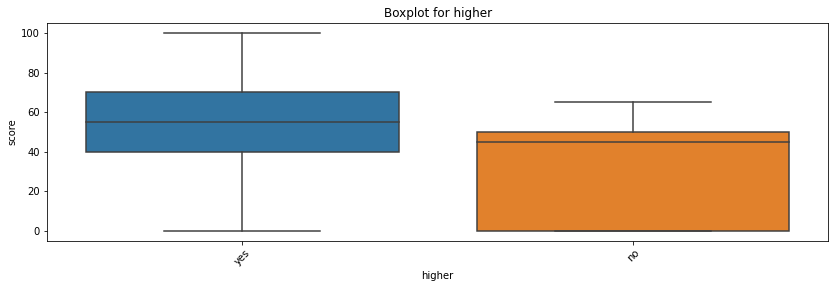

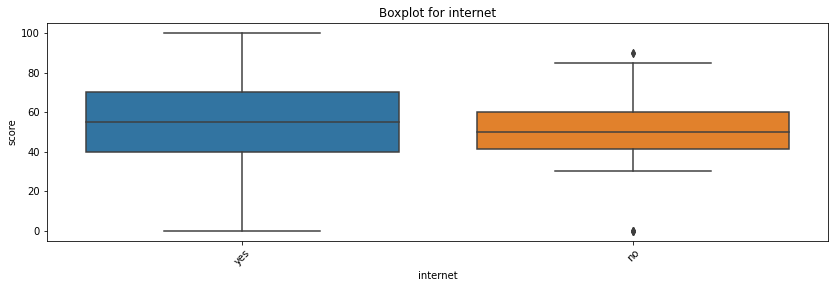

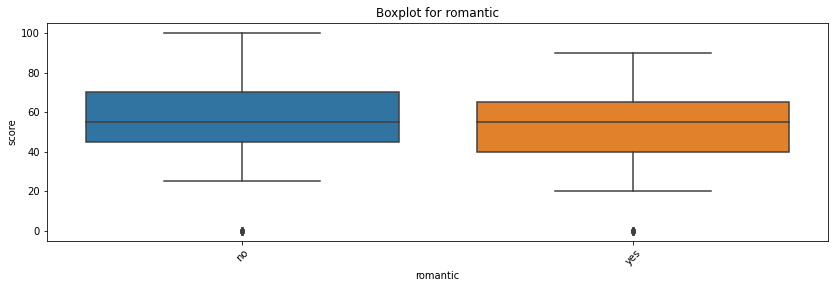

In [94]:
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']:
    get_boxplot(col, 'score', unsf)

In [95]:
for col in ['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob',
            'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid',
            'activities', 'nursery', 'higher', 'internet', 'romantic']:
    get_stat_dif(col, 'score', unsf)

Найдены статистически значимые различия для колонки Mjob


# Выводы

Данные имеют мало пропусков, и мало невалидных значений. Выбросов так же практически нет.
В целом датасет хорошего качества.

Выделены колонки который возможно существенно влияют на результат.

Остаются колонки для дальнейшей интерпретации : score, age, Medu, Fedu, studytime, failures ,goout, Mjob


In [96]:
# Выделены колонки который возможно существенно влияют на результат.

unsf_for_model = unsf.loc[:, ['score', 'age', 'Medu',
                              'Fedu', 'studytime','studytime, granular',
                              'failures', 'goout', 'Mjob']]
unsf_for_model.head()

,score,age,Medu,Fedu,studytime,"studytime, granular",failures,goout,Mjob
0,30.0,18,4.0,4.0,2.0,-6.0,0.0,4.0,at_home
1,30.0,17,1.0,1.0,2.0,-6.0,0.0,3.0,at_home
2,50.0,15,1.0,1.0,2.0,-6.0,3.0,2.0,at_home
3,75.0,15,4.0,2.0,3.0,-9.0,0.0,2.0,health
4,50.0,16,3.0,3.0,2.0,-6.0,0.0,2.0,other


### Интерпретация

0. В целом корреляция числовых переменных не очень сильная но присутсвет. Отсортируем для анализа показатели корреляция которых с целевым показателем больше чем 0.1. Рассмотрим от показатели от сильной связи к слабой.
1. "failures" - (-0.33) Говорит о том что наличае проблем вне школы отрицательно влияет на оценку по математике. Можно предположить что, чем чаще случается неудаче тем ниже самооценка, и выше уровень стресса перед сложными задачми. А математика требует высокой концентрации.

2. "Medu" - (0.22) Очевидно что мамы проводят больше, об этом говорит распределения параметра "guardian". Поэтому чем выше уровень образования у мамы, тем эффективнее она помогает ученику. 

3. "age" - (-0.15) Чем выше возраст, тем концентрированей жизнь, больше событий социального значения, и выше шанс потерпеть неудачу, о чем показывает корреляцию параметра age и failures. Соответсвенно чем выше возраст тем шанс получить хороший бал меньше.

4. "gout" - (-0.13)отрицательно влияет на результат, но не значительно,  и почти обратно пропорционально "studytime" (0.11), что логично. Больше времени на учебу лучше результат.

5. "Fedu" - (0.11) - Качественно, влияет наверно так же как и уровень образования мам, но то что папы проводят существенно меньше времени с детьми, то и влияние этого параметра ниже.

5. "studytime, granular" - ( -0.11) Обратная величина "studytime". Оставим для дальнейшего анализа.

6. "Mjob" - самый не очевидный показатель, наверняка есть связь с  временем проведенным с ребенком, или с уровенем образования. А следовательно и на результат см. пункты выше.

# Комментарий для ментора

Спасибо вам, думаю что вопросы задам на вебинаре, после того как получу замечания.